In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!unzip '/content/drive/MyDrive/Colab Notebooks/Zindi - Microsoft Rice Disease Classification Challenge/Images.zip' -d '/content/images/'

In [ ]:
import requests
from tqdm.auto import tqdm

def zindi_data_downloader(url, token, file_name):
  competition_data = requests.post(url=url, data= token, stream=True)
  pbar = tqdm(desc=file_name, total=int(competition_data.headers.get('content-length', 0)), unit='B', unit_scale=True, unit_divisor=512)
  handle = open(file_name, "wb")
  for chunk in competition_data.iter_content(chunk_size=512):
    if chunk: 
      handle.write(chunk)
    pbar.update(len(chunk))
  handle.close()
  pbar.close()

url = "https://api.zindi.africa/v1/competitions/digital-africa-plantation-counting-challenge/files/Test.csv"
zindi_data_downloader(url=url, token={'auth_token': 'Lcg4FUs5Fq7YkyCKrQe8rg5A'}, file_name='Test.csv')
url = "https://api.zindi.africa/v1/competitions/digital-africa-plantation-counting-challenge/files/Train.csv"
zindi_data_downloader(url=url, token={'auth_token': 'Lcg4FUs5Fq7YkyCKrQe8rg5A'}, file_name='Train.csv')
url = "https://api.zindi.africa/v1/competitions/digital-africa-plantation-counting-challenge/files/SampleSubmission.csv"
zindi_data_downloader(url=url, token={'auth_token': 'Lcg4FUs5Fq7YkyCKrQe8rg5A'}, file_name='SampleSubmission.csv')
url = "https://api.zindi.africa/v1/competitions/digital-africa-plantation-counting-challenge/files/TreeImages.zip"
zindi_data_downloader(url=url, token={'auth_token': 'Lcg4FUs5Fq7YkyCKrQe8rg5A'}, file_name='TreeImages.zip')
!unzip -q /content/TreeImages.zip -d /content/images/

Test.csv:   0%|          | 0.00/30.2k [00:00<?, ?B/s]

Train.csv:   0%|          | 0.00/87.6k [00:00<?, ?B/s]

SampleSubmission.csv:   0%|          | 0.00/33.5k [00:00<?, ?B/s]

TreeImages.zip:   0%|          | 0.00/29.8G [00:00<?, ?B/s]

In [ ]:
%%capture
!pip install albumentations==1.3.0
!pip install torchvision==0.15.1
!pip install torch==2.0.0

In [ ]:
import re, sys, glob, time, os, math, random, shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tqdm
from matplotlib import pyplot as plt

from PIL import Image
import cv2 as cv

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.ensemble import *

torch.__version__, torchvision.__version__, A.__version__

('2.0.0+cu118', '0.15.1+cu118', '1.3.0')

# **DATA**

In [ ]:
def set_seed(seed=42):
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  os.environ['PYTHONHASHSEED'] = str(seed)

def get_db_ensamble(model_name, is_oof=True, zero_images=None):
  if is_oof:
    db = pd.read_csv(f'{model_name}_oof.csv')
  else:
    db = pd.read_csv(f'{model_name}_test.csv')
  if zero_images is not None:
    db.loc[db['ImageId'].isin(zero_images), 'pred'] = 0
  return db.pred.values.reshape(-1, 1)

dim_base = 288
base_path = '/content/'

(2002, 2) (858, 1)
(array([0, 1, 2, 3, 4]), array([1298,  359,  126,  189,   30]))


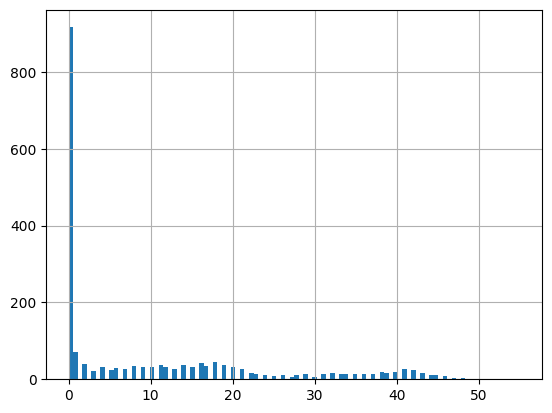

ImageId  Target
0  Id_jdqw9hlv6j.png    14.0
1  Id_6xtrolmuvc.png    18.0
2  Id_2m49sj3xd9.png     0.0
3  Id_9jwg5pcnn4.png    28.0
4  Id_vnm6e8n0p3.png    21.0

In [ ]:
train_df = pd.read_csv(base_path + 'Train.csv')
test_df = pd.read_csv(base_path + 'Test.csv')

print(train_df.shape, test_df.shape)
bins = pd.cut(train_df.Target, bins=5, labels=False).to_numpy()
print(np.unique(bins, return_counts=True))

train_df.Target.hist(bins=100)
plt.show()

train_df.head()

In [ ]:
big_error = [
    'Id_lp4yl8q9n2.png',
    'Id_lh8b1k1lx8.png',
    'Id_2r2259ynzp.png',
    'Id_u45dpub99b.png',
    'Id_kzuy1er5jm.png',
    'Id_xzj09h1xrm.png',
    'Id_4x0zh3y93q.png',
    'Id_6ls94ewz47.png',
    'Id_w4fnd54go8.png',
    'Id_r405nptkvd.png',
    'Id_n0ipc9o8el.png'
    ]
train_df = train_df[~train_df['ImageId'].isin(big_error)]

## **ZERO IMAGES**

In [ ]:
def load_img(path):
  image_dir='/content/images'
  image = cv.cvtColor(cv.imread(f'{image_dir}/{path}'), cv.COLOR_BGR2RGB)
  return image.sum()

zeroes_images_train = train_df.copy()
zeroes_images_train['sum_img_val'] = zeroes_images_train['ImageId'].apply(lambda x : load_img(x))

zeroes_images_train = zeroes_images_train[zeroes_images_train['sum_img_val'] == 0]
print(len(zeroes_images_train), zeroes_images_train.Target.sum(), zeroes_images_train.Target.max())

zeroes_images_train.head()

580 0.0 0.0


ImageId  Target  sum_img_val
5  Id_nro5x2z9p2.png     0.0            0
6  Id_g4c6aa4l1z.png     0.0            0
7  Id_j2fzjybuqv.png     0.0            0
8  Id_5beb0oyc43.png     0.0            0
9  Id_uirh42cj8d.png     0.0            0

zero image hold: Id_nro5x2z9p2.png


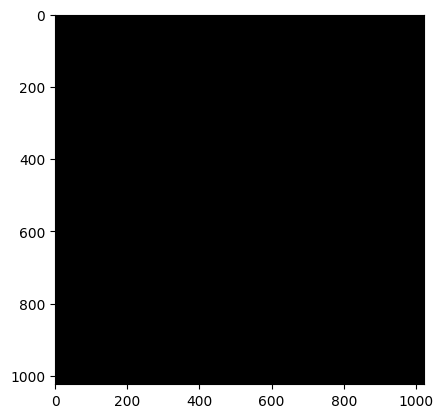

ImageId  Target
0  Id_nro5x2z9p2.png       0

In [ ]:
to_drop = zeroes_images_train.ImageId.values
print('zero image hold:', to_drop[0])

image = cv.imread('/content/images/Id_nro5x2z9p2.png')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

zero_image_hold_df = pd.DataFrame([[to_drop[0], 0]], columns=['ImageId', 'Target'])
zero_image_hold_df

# **DATASET FUNCTION**

In [ ]:
class Plantation(Dataset):
  def __init__(self, dataframe, image_dir, transforms=None, train=True, mosaic=(False, 288)):
    super().__init__()
    self.df = dataframe.values
    self.train = train
    self.image_dir = image_dir
    self.transforms = transforms
    self.mosaic = mosaic

  def __getitem__(self, idx: int):
    records = self.df[idx]
    image = cv.imread(f'{self.image_dir}/{records[0]}')
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    if self.train is True:
      rnd = random.random()
      if (self.mosaic[0] is True) and (rnd < 0.1):
        records_2 = self.df[random.randint(0, self.__len__() - 1)]
        records_3 = self.df[random.randint(0, self.__len__() - 1)]
        records_4 = self.df[random.randint(0, self.__len__() - 1)]
        image = np.vstack([
            np.hstack([
                image, 
                cv.cvtColor(cv.imread(f'{self.image_dir}/{records_2[0]}'), cv.COLOR_BGR2RGB)
                ]), 
            np.hstack([
                cv.cvtColor(cv.imread(f'{self.image_dir}/{records_3[0]}'), cv.COLOR_BGR2RGB), 
                cv.cvtColor(cv.imread(f'{self.image_dir}/{records_4[0]}'), cv.COLOR_BGR2RGB)
                ])
            ])
        labels = torch.Tensor([records[1] + records_2[1] + records_3[1] + records_4[1]]).type(torch.float32)
        transform = A.Compose([
            A.Resize(self.mosaic[1], self.mosaic[1], interpolation=cv.INTER_CUBIC),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
            ToTensorV2(p=1.0),
            ], p=1.0)
        return transform(image=image)['image'], labels

    if self.transforms:
      image = self.transforms(image=image)

    if self.train is True:
      labels = torch.Tensor([records[1]]).type(torch.float32) 
      return image['image'], labels
    else:
      return image['image']

  def __len__(self) -> int:
    return len(self.df)

def train_transform(dim=dim_base):
  return A.Compose([
      A.Resize(dim , dim, interpolation=cv.INTER_LINEAR),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      A.Transpose(p=0.5),
      A.Rotate(limit=45, border_mode=cv.BORDER_CONSTANT, mask_value=0, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
      A.OneOf([
          A.MotionBlur(blur_limit=3, p=0.5),
          A.MedianBlur(blur_limit=3, p=0.5),
          A.Blur(blur_limit=3, p=0.5),
          ], p=0.25),
      A.GaussNoise(0.2),
      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
      ToTensorV2(p=1.0),
      ])

def valid_transform(dim=dim_base):
  return A.Compose([
      A.Resize(dim , dim, interpolation=cv.INTER_LINEAR),
      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
      ToTensorV2(p=1.0)
      ])

def tta_transform(dim=dim_base):
  return A.Compose([
      A.Resize(dim , dim, interpolation=cv.INTER_LINEAR),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      A.Transpose(p=0.5),
      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
      ToTensorV2(p=1.0)
      ])

In [ ]:
x_train, x_val = train_test_split(train_df, test_size=0.1, random_state=42)
print(x_train.shape, x_val.shape)
# train_dataset = Plantation(x_train, '/content/images', train_transform(), train=True, mosaic=(True, 288))
train_dataset = Plantation(x_train, '/content/images', train_transform(), train=True, mosaic=(False, None))

random_image = random.randint(0, len(x_train) - 1)
image_label = train_dataset[random_image]
image = image_label[0].permute(1, 2, 0).numpy()
label = int(image_label[1].numpy()[0])
plt.title(f'Plantations: {label}')
plt.imshow(image)
plt.show()

In [ ]:
test_dataset = Plantation(test_df, '/content/images', valid_transform(), train=False)

random_image = random.randint(0, len(test_df) - 1)
image_label = test_dataset[random_image]
image = image_label.permute(1, 2, 0).numpy()
plt.imshow(image)
plt.show()

# **TRAINING**

https://pytorch.org/vision/0.14/models.html#table-of-all-available-classification-weights



In [ ]:
class Net(nn.Module):
  def __init__(self, name, weights=None):
    super(Net, self).__init__()
    if name == 'resnet18':
      self.model = models.resnet18(weights=weights)
      self.model.fc = nn.Linear(self.model.fc.in_features, 1)
    if name == 'resnet50':
      self.model = models.resnet50(weights=weights)
      self.model.fc = nn.Linear(self.model.fc.in_features, 1)
    if name == 'inception_v3':
      self.model = models.resnet50(weights=weights)
      self.model.fc = nn.Linear(self.model.fc.in_features, 1)
    if name == 'efficientnet_b1':
      self.model = models.efficientnet_b1(weights=weights)
      self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)
    if name == 'efficientnet_b2':
      self.model = models.efficientnet_b2(weights=weights)
      self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)
    if name == 'efficientnet_b4':
      self.model = models.efficientnet_b4(weights=weights)
      self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)
    if name == 'convnext_small':
      self.model = models.convnext_small(weights=weights)
      self.model.classifier[2] = nn.Linear(self.model.classifier[2].in_features, 1)
    if name == 'wide_resnet50_2':
      self.model = models.wide_resnet50_2(weights=weights)
      self.model.fc = nn.Linear(self.model.fc.in_features, 1)
    if name == 'efficientnet_v2_s':
      self.model = models.efficientnet_v2_s(weights=weights)
      self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)
    if name == 'efficientnet_v2_m':
      self.model = models.efficientnet_v2_m(weights=weights)
      self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)
    if name == 'regnet_x_16gf':
      self.model = models.regnet_x_16gf(weights=weights)
      self.model.fc = nn.Linear(self.model.fc.in_features, 1)
    if name == 'resnext50_32x4d':
      self.model = models.resnext50_32x4d(weights=weights)
      self.model.fc = nn.Linear(self.model.fc.in_features, 1)
    if name == 'vit_b_16':
      self.model = models.vit_b_16(weights=weights)
      self.model.heads[0] = nn.Linear(self.model.heads[0].in_features, 1)
    if name == 'swin_v2_t':
      self.model = models.swin_v2_t(weights=weights)
      self.model.head = nn.Linear(self.model.head.in_features, 1)
    if name == 'maxvit_t':
      self.model = models.maxvit_t(weights=weights)
      self.model.classifier[5] = nn.Linear(self.model.classifier[5].in_features, 1)

  def forward(self, x):
    x = self.model(x)
    return x

In [ ]:
loss = nn.MSELoss()

def loss_fn(pred, true):
  return torch.sqrt(loss(pred, true))

def train_fn(data_loader, model, optimizer, device, scheduler, amp=False, disable=True):
  model.train()
  scaler = torch.cuda.amp.GradScaler(enabled=amp)
  tk0 = tqdm(data_loader, total=len(data_loader), disable=disable)
  train_loss = []
  for step, (images, label) in enumerate(tk0):

    images = images.to(device).float()
    label = label.to(device).float()

    optimizer.zero_grad()
    with autocast(enabled=amp):
      out = model(images)
      loss = loss_fn(out, label)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    if scheduler is not None:
      scheduler.step()

    tk0.set_postfix(loss=loss.detach().cpu().numpy())
    train_loss.append(loss.detach().cpu().numpy())
  return np.mean(train_loss)

def eval_fn(data_loader, model, device, disable=True):
  model.eval()
  valid_loss = []
  preds_out = []
  with torch.no_grad():
    tk0 = tqdm(data_loader, total=len(data_loader), disable=disable)
    for step, (images, label) in enumerate(tk0):

      images = images.to(device).float()
      label = label.to(device).float()

      out = model(images)
      loss = loss_fn(out, label)

      tk0.set_postfix(loss=loss.detach().cpu().numpy())
      valid_loss.append(loss.detach().cpu().numpy())
      preds_out.append(out.detach().cpu().numpy())
  return np.mean(valid_loss), np.concatenate(preds_out, axis=0)

def test_fn(data_loader, model, device):
  model.eval()
  pred = []
  with torch.no_grad():
    for images in data_loader:
      images = images.to(device).float()
      out = model(images)
      pred.append(out.detach().cpu().numpy())
  return np.concatenate(pred, axis=0)

def predict(model, weights, save_path_fold, dim=288, apply_tta=False, device='cuda', n_tta=5):
  if apply_tta:
    data = Plantation(test_df, '/content/images', tta_transform(dim=dim), train=False)
  else:
    data = Plantation(test_df, '/content/images', valid_transform(dim=dim), train=False)
  
  test_loader = DataLoader(data, batch_size=bs, shuffle=False, num_workers=2)

  model = Net(model, weights=weights)
  model.load_state_dict(torch.load(save_path_fold))
  model.to(device)

  if apply_tta:
    predictions = np.zeros(shape=(test_df.shape[0], 1))
    set_seed()
    for _ in range(n_tta):
      tta_predictions = test_fn(test_loader, model, device)
      predictions += tta_predictions / n_tta
  else:
    predictions = test_fn(test_loader, model, device)
  return predictions

## **SCHEDULER**

/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


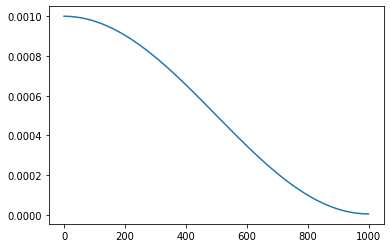

In [ ]:
split = 5
bs = 16
skf = StratifiedKFold(n_splits=split, shuffle=True, random_state=42)
bins = pd.cut(train_df.Target, bins=5, labels=False).to_numpy()
for fold, (train_index, test_index) in enumerate(skf.split(train_df, bins)):
  train = train_df.iloc[train_index]
  train_data_loader = DataLoader(Plantation(train, '/content/images', train_transform()), shuffle=True, batch_size=bs, num_workers=2)

model = torch.nn.Linear(2, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# lr_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, pct_start=0.25, div_factor=1e2, max_lr=1e-3, epochs=EPOCHS, steps_per_epoch=len(train_data_loader), verbose=False)
# lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=len(train_data_loader) * 10, T_mult=2, eta_min=5e-6, verbose=False)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_data_loader)* 10, eta_min=5e-6, last_epoch=-1, verbose=False)

lrs = []
for i in range(len(train_data_loader) * 10):
    lr_sched.step()
    lrs.append(optimizer.param_groups[0]["lr"])

plt.plot(lrs)
plt.show()

## **MODEL:** efficientnet_b1

score 5 fold: 2.206665143

In [ ]:
name = "efficientnet_b1"
weights='IMAGENET1K_V2'
dim = 288
num_epochs = 10
bs = 16
split = 5
skf = StratifiedKFold(n_splits=split, shuffle=True, random_state=42)
oof = np.zeros(shape=(train_df.shape[0], 1))
test_pred = np.zeros(shape=(test_df.shape[0], 1))

bins = pd.cut(train_df.Target, bins=6, labels=False).to_numpy()
for fold, (train_index, test_index) in enumerate(skf.split(train_df, bins)):
  set_seed()
  
  train = train_df.iloc[train_index]
  train = pd.concat([train[~train['ImageId'].isin(to_drop)], zero_image_hold_df], axis=0).reset_index(drop=True)
  valid = train_df.iloc[test_index]
  print('#' * 50)
  print(train.shape, valid.shape)

  train_data_loader = DataLoader(Plantation(train, '/content/images', train_transform(dim=dim), mosaic=(False, dim)), shuffle=True, batch_size=bs, num_workers=2)
  valid_data_loader = DataLoader(Plantation(valid, '/content/images', valid_transform(dim=dim)), shuffle=False, batch_size=bs, num_workers=2)

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model = Net(name, weights=weights)
  model.to(device)

  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_data_loader)* 10, eta_min=1e-5, verbose=False)

  save_path_fold = f'/content/{name}_{fold + 1}.pth'
  best_loss = np.inf
  for epoch in range(num_epochs):
    train_loss = train_fn(train_data_loader, model, optimizer, device, lr_scheduler, amp=False, disable=False)
    valid_loss, valid_pred_out = eval_fn(valid_data_loader, model, device, disable=True)
    valid_loss = mean_squared_error(valid.Target.values.flatten(), valid_pred_out.flatten(), squared=False)

    if valid_loss < best_loss:
      best_loss, valid_pred = valid_loss, valid_pred_out
      torch.save(model.state_dict(), save_path_fold)
      print('|FOLD {}| EPOCH {}| TRAIN LOSS {}| VALID LOSS {}|'.format(fold + 1, epoch + 1, train_loss, valid_loss))

  oof[test_index] = valid_pred
  test_pred += (
      predict(name, weights, save_path_fold, dim=dim, apply_tta=True, device=device, n_tta=4) * 0.5 + 
      predict(name, weights, save_path_fold, dim=dim, device=device) * 0.5
  ) / split
  # test_pred = (
  #     predict(name, weights, save_path_fold, dim=dim, apply_tta=True, device=device, n_tta=4) * 0.5 + 
  #     predict(name, weights, save_path_fold, dim=dim, device=device) * 0.5
  # )
  # break

print('#' * 50)
print(f"RMSE OOF: {mean_squared_error(train_df.Target.values.flatten(), oof.flatten(), squared=False)}")
oof_save, test_save = train_df.copy(), test_df.copy()
oof_save['pred'] = oof
test_save['pred'] = test_pred
oof_save.to_csv(f'{name}_oof.csv', index=False)
test_save.to_csv(f'{name}_test.csv', index=False)

##################################################
(1124, 2) (399, 2)


Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 79.3MB/s]


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 1| TRAIN LOSS 9.116666793823242| VALID LOSS 4.886925106021235|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 2| TRAIN LOSS 5.2150726318359375| VALID LOSS 3.9446663019603703|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 3| TRAIN LOSS 4.959169864654541| VALID LOSS 3.248989129680278|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 4| TRAIN LOSS 4.291309356689453| VALID LOSS 2.5508183651226015|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 5| TRAIN LOSS 3.471275806427002| VALID LOSS 2.2871702736983477|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 6| TRAIN LOSS 2.9989047050476074| VALID LOSS 1.9957014602274612|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 7| TRAIN LOSS 2.8235294818878174| VALID LOSS 1.941712253347135|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 8| TRAIN LOSS 2.641528367996216| VALID LOSS 1.817784391665791|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

##################################################
(1138, 2) (398, 2)


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 1| TRAIN LOSS 8.54800796508789| VALID LOSS 4.759520365079864|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 2| TRAIN LOSS 5.505321025848389| VALID LOSS 3.957408200376979|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 3| TRAIN LOSS 4.398386001586914| VALID LOSS 3.707780280515021|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 4| TRAIN LOSS 4.074008464813232| VALID LOSS 3.094127260117934|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 5| TRAIN LOSS 3.3786191940307617| VALID LOSS 2.4985384793155805|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 6| TRAIN LOSS 2.9730076789855957| VALID LOSS 2.4316857974628623|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 7| TRAIN LOSS 2.6215367317199707| VALID LOSS 2.1742559463486404|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 8| TRAIN LOSS 2.439675807952881| VALID LOSS 2.0864525392459567|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 9| TRAIN LOSS 2.2845470905303955| VALID LOSS 2.0165913271485416|


  0%|          | 0/72 [00:00<?, ?it/s]

##################################################
(1117, 2) (398, 2)


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 1| TRAIN LOSS 9.69548225402832| VALID LOSS 3.5479308069083633|


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 2| TRAIN LOSS 5.051815509796143| VALID LOSS 2.804027352998955|


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 3| TRAIN LOSS 4.651112079620361| VALID LOSS 2.3955716096069124|


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 6| TRAIN LOSS 3.0180113315582275| VALID LOSS 2.2738817376775833|


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 8| TRAIN LOSS 2.6285834312438965| VALID LOSS 1.9728423375041086|


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 9| TRAIN LOSS 2.342068672180176| VALID LOSS 1.92199755592753|


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 10| TRAIN LOSS 2.4292972087860107| VALID LOSS 1.9193197241232482|
##################################################
(1137, 2) (398, 2)


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 1| TRAIN LOSS 9.140216827392578| VALID LOSS 4.090834765578363|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 2| TRAIN LOSS 5.595061302185059| VALID LOSS 3.450730533782935|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 3| TRAIN LOSS 4.323676109313965| VALID LOSS 2.6507901707887696|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 5| TRAIN LOSS 3.7410638332366943| VALID LOSS 2.1760737753951145|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 6| TRAIN LOSS 3.1805295944213867| VALID LOSS 1.952856345025842|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 8| TRAIN LOSS 2.9655864238739014| VALID LOSS 1.8990900868061764|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 10| TRAIN LOSS 2.3125383853912354| VALID LOSS 1.8278513954139932|
##################################################
(1133, 2) (398, 2)


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 1| TRAIN LOSS 9.469352722167969| VALID LOSS 3.629131769349553|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 2| TRAIN LOSS 5.054862022399902| VALID LOSS 2.782905337686331|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 3| TRAIN LOSS 4.305241584777832| VALID LOSS 2.2872580208744213|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 5| TRAIN LOSS 3.1009089946746826| VALID LOSS 2.231010485566615|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 6| TRAIN LOSS 2.842015266418457| VALID LOSS 1.9418647912826608|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 7| TRAIN LOSS 2.657892942428589| VALID LOSS 1.925698421302931|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 9| TRAIN LOSS 2.406060218811035| VALID LOSS 1.8833354444251482|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 10| TRAIN LOSS 2.297835111618042| VALID LOSS 1.8813841004463185|
##################################################
RMSE OOF: 1.8939221569527473


## **MODEL:** resnet50

score 5 fold: 2.169329905

In [ ]:
name = "resnet50"
weights='IMAGENET1K_V2'
dim = 288
num_epochs = 10
bs = 16
split = 5
skf = StratifiedKFold(n_splits=split, shuffle=True, random_state=42)
oof = np.zeros(shape=(train_df.shape[0], 1))
test_pred = np.zeros(shape=(test_df.shape[0], 1))

bins = pd.cut(train_df.Target, bins=6, labels=False).to_numpy()
for fold, (train_index, test_index) in enumerate(skf.split(train_df, bins)):
  set_seed()
  
  train = train_df.iloc[train_index]
  train = pd.concat([train[~train['ImageId'].isin(to_drop)], zero_image_hold_df], axis=0).reset_index(drop=True)
  valid = train_df.iloc[test_index]
  print('#' * 50)
  print(train.shape, valid.shape)

  train_data_loader = DataLoader(Plantation(train, '/content/images', train_transform(dim=dim), mosaic=(False, dim)), shuffle=True, batch_size=bs, num_workers=2)
  valid_data_loader = DataLoader(Plantation(valid, '/content/images', valid_transform(dim=dim)), shuffle=False, batch_size=bs, num_workers=2)

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model = Net(name, weights=weights)
  model.to(device)

  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_data_loader)* 10, eta_min=1e-5, verbose=False)

  save_path_fold = f'/content/{name}_{fold + 1}.pth'
  best_loss = np.inf
  for epoch in range(num_epochs):
    train_loss = train_fn(train_data_loader, model, optimizer, device, lr_scheduler, amp=False, disable=False)
    valid_loss, valid_pred_out = eval_fn(valid_data_loader, model, device, disable=True)
    valid_loss = mean_squared_error(valid.Target.values.flatten(), valid_pred_out.flatten(), squared=False)

    if valid_loss < best_loss:
      best_loss, valid_pred = valid_loss, valid_pred_out
      torch.save(model.state_dict(), save_path_fold)
      print('|FOLD {}| EPOCH {}| TRAIN LOSS {}| VALID LOSS {}|'.format(fold + 1, epoch + 1, train_loss, valid_loss))

  oof[test_index] = valid_pred
  test_pred += (
      predict(name, weights, save_path_fold, dim=dim, apply_tta=True, device=device, n_tta=4) * 0.5 + 
      predict(name, weights, save_path_fold, dim=dim, device=device) * 0.5
  ) / split
  # test_pred = (
  #     predict(name, weights, save_path_fold, dim=dim, apply_tta=True, device=device, n_tta=4) * 0.5 + 
  #     predict(name, weights, save_path_fold, dim=dim, device=device) * 0.5
  # )
  # break

print('#' * 50)
print(f"RMSE OOF: {mean_squared_error(train_df.Target.values.flatten(), oof.flatten(), squared=False)}")
oof_save, test_save = train_df.copy(), test_df.copy()
oof_save['pred'] = oof
test_save['pred'] = test_pred
oof_save.to_csv(f'{name}_oof.csv', index=False)
test_save.to_csv(f'{name}_test.csv', index=False)

##################################################
(1124, 2) (399, 2)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 1| TRAIN LOSS 8.879959106445312| VALID LOSS 4.087712788155551|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 3| TRAIN LOSS 4.005181789398193| VALID LOSS 3.4233945639184173|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 4| TRAIN LOSS 3.585582733154297| VALID LOSS 2.817392709583976|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 6| TRAIN LOSS 3.039550542831421| VALID LOSS 2.42708075755623|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 8| TRAIN LOSS 2.538686990737915| VALID LOSS 2.0043474228578297|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

##################################################
(1138, 2) (398, 2)


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 1| TRAIN LOSS 10.164444923400879| VALID LOSS 3.427757299863989|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 3| TRAIN LOSS 3.6909265518188477| VALID LOSS 2.7637824340818717|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 5| TRAIN LOSS 3.247122287750244| VALID LOSS 2.3933925794568323|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 7| TRAIN LOSS 2.7145566940307617| VALID LOSS 2.245145498314624|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 8| TRAIN LOSS 2.4511783123016357| VALID LOSS 2.2037340321597076|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

##################################################
(1117, 2) (398, 2)


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 1| TRAIN LOSS 10.296610832214355| VALID LOSS 3.9385093884156506|


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 2| TRAIN LOSS 5.675897121429443| VALID LOSS 3.114426496115357|


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 3| TRAIN LOSS 4.981328010559082| VALID LOSS 2.879475127991609|


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 4| TRAIN LOSS 3.669511079788208| VALID LOSS 2.425140305791665|


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 6| TRAIN LOSS 3.2715706825256348| VALID LOSS 2.085058715547695|


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 8| TRAIN LOSS 2.400387763977051| VALID LOSS 2.0009303363436413|


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 9| TRAIN LOSS 2.4230451583862305| VALID LOSS 1.9471131526355925|


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 10| TRAIN LOSS 2.310641050338745| VALID LOSS 1.8645520884856535|
##################################################
(1137, 2) (398, 2)


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 1| TRAIN LOSS 9.043752670288086| VALID LOSS 5.244158611639221|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 2| TRAIN LOSS 5.070678234100342| VALID LOSS 3.860527474524874|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 4| TRAIN LOSS 3.9308319091796875| VALID LOSS 3.4546443644828635|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 5| TRAIN LOSS 3.2051706314086914| VALID LOSS 2.523153925420531|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 6| TRAIN LOSS 2.8025901317596436| VALID LOSS 2.263986471327708|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 8| TRAIN LOSS 2.3911845684051514| VALID LOSS 2.0119988496968286|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

##################################################
(1133, 2) (398, 2)


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 1| TRAIN LOSS 9.69277572631836| VALID LOSS 7.535752482519348|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 3| TRAIN LOSS 3.841580629348755| VALID LOSS 2.6494259401475095|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 6| TRAIN LOSS 2.903909921646118| VALID LOSS 2.070326380396656|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 9| TRAIN LOSS 2.3221168518066406| VALID LOSS 1.9096383664465322|


  0%|          | 0/71 [00:00<?, ?it/s]

##################################################
RMSE OOF: 2.0022630102945076


## **MODEL:** resnext50_32x4d

score 5 fold: 2.184242089

In [ ]:
name = "resnext50_32x4d"
weights='IMAGENET1K_V2'
dim = 288
num_epochs = 10
bs = 16
split = 5
skf = StratifiedKFold(n_splits=split, shuffle=True, random_state=42)
oof = np.zeros(shape=(train_df.shape[0], 1))
test_pred = np.zeros(shape=(test_df.shape[0], 1))

bins = pd.cut(train_df.Target, bins=6, labels=False).to_numpy()
for fold, (train_index, test_index) in enumerate(skf.split(train_df, bins)):
  set_seed()
  
  train = train_df.iloc[train_index]
  train = pd.concat([train[~train['ImageId'].isin(to_drop)], zero_image_hold_df], axis=0).reset_index(drop=True)
  valid = train_df.iloc[test_index]
  print('#' * 50)
  print(train.shape, valid.shape)

  train_data_loader = DataLoader(Plantation(train, '/content/images', train_transform(dim=dim), mosaic=(False, dim)), shuffle=True, batch_size=bs, num_workers=2)
  valid_data_loader = DataLoader(Plantation(valid, '/content/images', valid_transform(dim=dim)), shuffle=False, batch_size=bs, num_workers=2)

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model = Net(name, weights=weights)
  model.to(device)

  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_data_loader)* 10, eta_min=1e-5, verbose=False)

  save_path_fold = f'/content/{name}_{fold + 1}.pth'
  best_loss = np.inf
  for epoch in range(num_epochs):
    train_loss = train_fn(train_data_loader, model, optimizer, device, lr_scheduler, amp=False, disable=False)
    valid_loss, valid_pred_out = eval_fn(valid_data_loader, model, device, disable=True)
    valid_loss = mean_squared_error(valid.Target.values.flatten(), valid_pred_out.flatten(), squared=False)

    if valid_loss < best_loss:
      best_loss, valid_pred = valid_loss, valid_pred_out
      torch.save(model.state_dict(), save_path_fold)
      print('|FOLD {}| EPOCH {}| TRAIN LOSS {}| VALID LOSS {}|'.format(fold + 1, epoch + 1, train_loss, valid_loss))

  oof[test_index] = valid_pred
  test_pred += (
      predict(name, weights, save_path_fold, dim=dim, apply_tta=True, device=device, n_tta=4) * 0.5 + 
      predict(name, weights, save_path_fold, dim=dim, device=device) * 0.5
  ) / split
  # test_pred = (
  #     predict(name, weights, save_path_fold, dim=dim, apply_tta=True, device=device, n_tta=4) * 0.5 + 
  #     predict(name, weights, save_path_fold, dim=dim, device=device) * 0.5
  # )
  # break

print('#' * 50)
print(f"RMSE OOF: {mean_squared_error(train_df.Target.values.flatten(), oof.flatten(), squared=False)}")
oof_save, test_save = train_df.copy(), test_df.copy()
oof_save['pred'] = oof
test_save['pred'] = test_pred
oof_save.to_csv(f'{name}_oof.csv', index=False)
test_save.to_csv(f'{name}_test.csv', index=False)

##################################################
(1124, 2) (399, 2)


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:02<00:00, 49.0MB/s]


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 1| TRAIN LOSS 8.055638313293457| VALID LOSS 10.767389074721281|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 2| TRAIN LOSS 5.5354743003845215| VALID LOSS 3.650452318464379|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 3| TRAIN LOSS 4.02506160736084| VALID LOSS 2.738622817419414|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 4| TRAIN LOSS 3.442769765853882| VALID LOSS 2.507245160544493|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 5| TRAIN LOSS 3.102027177810669| VALID LOSS 2.229558694384027|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 6| TRAIN LOSS 2.685178756713867| VALID LOSS 1.9994995565928697|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 7| TRAIN LOSS 2.652167558670044| VALID LOSS 1.9661281566281676|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 10| TRAIN LOSS 2.2056496143341064| VALID LOSS 1.8042122759400172|
##################################################
(1138, 2) (398, 2)


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 1| TRAIN LOSS 8.32680606842041| VALID LOSS 5.121381109010967|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 2| TRAIN LOSS 4.550730228424072| VALID LOSS 2.900507376469787|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 4| TRAIN LOSS 3.4758126735687256| VALID LOSS 2.8762475231388183|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 6| TRAIN LOSS 2.7318830490112305| VALID LOSS 2.8264244459065844|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 7| TRAIN LOSS 2.4737462997436523| VALID LOSS 2.6160542188188067|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 8| TRAIN LOSS 2.351633310317993| VALID LOSS 2.113782856774548|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

##################################################
(1117, 2) (398, 2)


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 1| TRAIN LOSS 8.120268821716309| VALID LOSS 3.970760433700165|


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 3| TRAIN LOSS 4.2703166007995605| VALID LOSS 3.3814192363761317|


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 5| TRAIN LOSS 2.9486732482910156| VALID LOSS 2.2908576236112235|


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 7| TRAIN LOSS 2.5657284259796143| VALID LOSS 1.928233501317047|


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

##################################################
(1137, 2) (398, 2)


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 1| TRAIN LOSS 8.751733779907227| VALID LOSS 5.935347024741798|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 3| TRAIN LOSS 4.033751487731934| VALID LOSS 3.1601972465077206|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 6| TRAIN LOSS 3.0105032920837402| VALID LOSS 2.6510247723113185|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 7| TRAIN LOSS 2.583350658416748| VALID LOSS 2.0967247469817627|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 8| TRAIN LOSS 2.2849225997924805| VALID LOSS 1.99737929331833|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

##################################################
(1133, 2) (398, 2)


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 1| TRAIN LOSS 8.4319429397583| VALID LOSS 4.394618003499864|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 2| TRAIN LOSS 4.619975566864014| VALID LOSS 3.320964777993198|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 4| TRAIN LOSS 3.2873380184173584| VALID LOSS 2.423373213641353|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 6| TRAIN LOSS 2.80552339553833| VALID LOSS 2.12286939370098|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 7| TRAIN LOSS 2.537501335144043| VALID LOSS 2.1019000372504624|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 9| TRAIN LOSS 2.2162837982177734| VALID LOSS 2.0093302746106145|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 10| TRAIN LOSS 2.109797477722168| VALID LOSS 1.920264136406231|
##################################################
RMSE OOF: 1.9553442214617651


## **MODEL:** inception_v3

score 5 fold: 2.185164975




In [ ]:
name = "inception_v3"
weights='IMAGENET1K_V1'
dim = 288
num_epochs = 10
bs = 16
split = 5
skf = StratifiedKFold(n_splits=split, shuffle=True, random_state=42)
oof = np.zeros(shape=(train_df.shape[0], 1))
test_pred = np.zeros(shape=(test_df.shape[0], 1))

bins = pd.cut(train_df.Target, bins=6, labels=False).to_numpy()
for fold, (train_index, test_index) in enumerate(skf.split(train_df, bins)):
  set_seed()
  
  train = train_df.iloc[train_index]
  train = pd.concat([train[~train['ImageId'].isin(to_drop)], zero_image_hold_df], axis=0).reset_index(drop=True)
  valid = train_df.iloc[test_index]
  print('#' * 50)
  print(train.shape, valid.shape)

  train_data_loader = DataLoader(Plantation(train, '/content/images', train_transform(dim=dim), mosaic=(False, dim)), shuffle=True, batch_size=bs, num_workers=2)
  valid_data_loader = DataLoader(Plantation(valid, '/content/images', valid_transform(dim=dim)), shuffle=False, batch_size=bs, num_workers=2)

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model = Net(name, weights=weights)
  model.to(device)

  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_data_loader)* 10, eta_min=1e-6, verbose=False)

  save_path_fold = f'/content/{name}_{fold + 1}.pth'
  best_loss = np.inf
  for epoch in range(num_epochs):
    train_loss = train_fn(train_data_loader, model, optimizer, device, lr_scheduler, amp=False, disable=False)
    valid_loss, valid_pred_out = eval_fn(valid_data_loader, model, device, disable=True)
    valid_loss = mean_squared_error(valid.Target.values.flatten(), valid_pred_out.flatten(), squared=False)

    if valid_loss < best_loss:
      best_loss, valid_pred = valid_loss, valid_pred_out
      torch.save(model.state_dict(), save_path_fold)
      print('|FOLD {}| EPOCH {}| TRAIN LOSS {}| VALID LOSS {}|'.format(fold + 1, epoch + 1, train_loss, valid_loss))

  oof[test_index] = valid_pred
  test_pred += (
      predict(name, weights, save_path_fold, dim=dim, apply_tta=True, device=device, n_tta=4) * 0.5 + 
      predict(name, weights, save_path_fold, dim=dim, device=device) * 0.5
  ) / split
  # test_pred = (
  #     predict(name, weights, save_path_fold, dim=dim, apply_tta=True, device=device, n_tta=4) * 0.5 + 
  #     predict(name, weights, save_path_fold, dim=dim, device=device) * 0.5
  # )
  # break

print('#' * 50)
print(f"RMSE OOF: {mean_squared_error(train_df.Target.values.flatten(), oof.flatten(), squared=False)}")
oof_save, test_save = train_df.copy(), test_df.copy()
oof_save['pred'] = oof
test_save['pred'] = test_pred
oof_save.to_csv(f'{name}_oof.csv', index=False)
test_save.to_csv(f'{name}_test.csv', index=False)

##################################################
(1124, 2) (399, 2)


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 1| TRAIN LOSS 10.523354530334473| VALID LOSS 6.424191436816161|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 2| TRAIN LOSS 4.799776077270508| VALID LOSS 2.707334838153745|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 4| TRAIN LOSS 3.417048454284668| VALID LOSS 2.303908020516061|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 5| TRAIN LOSS 3.086982011795044| VALID LOSS 2.058819584385851|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 1| EPOCH 8| TRAIN LOSS 2.638456344604492| VALID LOSS 1.8532248446699389|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

##################################################
(1138, 2) (398, 2)


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 1| TRAIN LOSS 10.847696304321289| VALID LOSS 4.294865814397132|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 2| TRAIN LOSS 5.069417476654053| VALID LOSS 3.1080757398580157|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 4| TRAIN LOSS 3.7585535049438477| VALID LOSS 2.7882279623440125|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 5| TRAIN LOSS 3.0395491123199463| VALID LOSS 2.285179606995246|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 7| TRAIN LOSS 2.739285945892334| VALID LOSS 2.1727374149036973|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 2| EPOCH 8| TRAIN LOSS 2.5366477966308594| VALID LOSS 2.129665851910358|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

##################################################
(1117, 2) (398, 2)


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 1| TRAIN LOSS 10.990774154663086| VALID LOSS 4.063227945688138|


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 2| TRAIN LOSS 4.834558963775635| VALID LOSS 2.315021925402414|


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 6| TRAIN LOSS 2.888817548751831| VALID LOSS 1.999617913797427|


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 7| TRAIN LOSS 2.7808098793029785| VALID LOSS 1.8251357345378487|


  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 8| TRAIN LOSS 2.4785945415496826| VALID LOSS 1.79011023999008|


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

|FOLD 3| EPOCH 10| TRAIN LOSS 2.3982415199279785| VALID LOSS 1.7349272504331112|
##################################################
(1137, 2) (398, 2)


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 1| TRAIN LOSS 10.686944961547852| VALID LOSS 5.292130085140469|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 2| TRAIN LOSS 4.7562432289123535| VALID LOSS 2.9009048606574797|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 4| TRAIN LOSS 3.689531087875366| VALID LOSS 2.434613514990463|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 6| TRAIN LOSS 2.677412748336792| VALID LOSS 1.9756861604713072|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 7| TRAIN LOSS 2.511417865753174| VALID LOSS 1.9061385241563709|


  0%|          | 0/72 [00:00<?, ?it/s]

|FOLD 4| EPOCH 8| TRAIN LOSS 2.3728113174438477| VALID LOSS 1.8593815015110777|


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

##################################################
(1133, 2) (398, 2)


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 1| TRAIN LOSS 10.597173690795898| VALID LOSS 3.0963206916113473|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 2| TRAIN LOSS 5.101919651031494| VALID LOSS 2.2353782464283642|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 4| TRAIN LOSS 3.5170481204986572| VALID LOSS 2.1914521678006476|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 6| TRAIN LOSS 2.8518383502960205| VALID LOSS 1.9987166824017164|


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 8| TRAIN LOSS 2.440722942352295| VALID LOSS 1.9672358082077126|


  0%|          | 0/71 [00:00<?, ?it/s]

|FOLD 5| EPOCH 9| TRAIN LOSS 2.4614436626434326| VALID LOSS 1.909661055349319|


  0%|          | 0/71 [00:00<?, ?it/s]

##################################################
RMSE OOF: 1.9017643645452225


# **SUBMISSION** 

In [ ]:
def load_img(path):
  image_dir='/content/images'
  image = cv.cvtColor(cv.imread(f'{image_dir}/{path}'), cv.COLOR_BGR2RGB)
  return image.sum()

zeroes_images = test_df.copy()
zeroes_images['sum_img_val'] = zeroes_images['ImageId'].apply(lambda x : load_img(x))
zeroes_images = zeroes_images[zeroes_images['sum_img_val'] == 0]
print(len(zeroes_images))

224


In [ ]:
name = "inception_v3"
ss_df = pd.read_csv(base_path + 'SampleSubmission.csv')
ss_df['Target'] = test_pred
ss_df.loc[ss_df['ImageId'].isin(zeroes_images.ImageId.values), 'Target'] = 0  # target 0 when image values is all 0
ss_df.to_csv(f'{name}.csv', index=False)
ss_df.head(5)

ImageId     Target
0  Id_ohk78h9ld8.png   0.000000
1  Id_eeyj2u4j7y.png   0.284192
2  Id_wsd7vx2ifa.png  13.865365
3  Id_6vfneamaoh.png  14.459177
4  Id_9wil3575fv.png  15.008656

In [ ]:
image = cv.imread('/content/images/Id_6vfneamaoh.png')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

# **ENSAMBLE**

In [ ]:
X_ensamble = np.hstack([
    get_db_ensamble('efficientnet_b1', is_oof=True, zero_images=to_drop),
    get_db_ensamble('resnext50_32x4d', is_oof=True, zero_images=to_drop),
    get_db_ensamble('resnet50', is_oof=True, zero_images=to_drop),
    get_db_ensamble('inception_v3', is_oof=True, zero_images=to_drop),
    ])
X_test_ensamble = np.hstack([
    get_db_ensamble('efficientnet_b1', is_oof=False, zero_images=zeroes_images.ImageId.values),
    get_db_ensamble('resnext50_32x4d', is_oof=False, zero_images=zeroes_images.ImageId.values),
    get_db_ensamble('resnet50', is_oof=False, zero_images=zeroes_images.ImageId.values),
    get_db_ensamble('inception_v3', is_oof=False, zero_images=zeroes_images.ImageId.values),
    ])
y_ensamble = train_df.Target.values

model = RandomForestRegressor(n_estimators=10, random_state=42)
# model = LinearRegression(fit_intercept=False)
model.fit(X_ensamble, y_ensamble)

name = "ensamble_ml"
ss_df = pd.read_csv(base_path + 'SampleSubmission.csv')
ss_df['Target'] = model.predict(X_test_ensamble)
ss_df.loc[ss_df['ImageId'].isin(zeroes_images.ImageId.values), 'Target'] = 0  # target 0 when image values is all 0
ss_df.to_csv(f'{name}.csv', index=False)
ss_df.head(5)

ImageId  Target
0  Id_ohk78h9ld8.png     0.0
1  Id_eeyj2u4j7y.png     0.0
2  Id_wsd7vx2ifa.png    13.0
3  Id_6vfneamaoh.png    18.0
4  Id_9wil3575fv.png    16.1

In [ ]:
model.feature_importances_

array([0.21360006, 0.78639994])

In [ ]:
name = "ensamble"
ss_df = pd.read_csv(base_path + 'SampleSubmission.csv')
ss_df['Target'] = np.mean([
    get_db_ensamble('efficientnet_b1', is_oof=False),
    get_db_ensamble('resnext50_32x4d', is_oof=False),
    get_db_ensamble('resnet50', is_oof=False),
    get_db_ensamble('inception_v3', is_oof=False),
    ], axis=0)
ss_df.loc[ss_df['ImageId'].isin(zeroes_images.ImageId.values), 'Target'] = 0  # target 0 when image values is all 0
ss_df.loc[ss_df['Target'] < 0, 'Target'] = 0  # target 0 when image values is all 0
ss_df.to_csv(f'{name}.csv', index=False)
ss_df.head(5)

ImageId     Target
0  Id_ohk78h9ld8.png   0.000000
1  Id_eeyj2u4j7y.png   0.095681
2  Id_wsd7vx2ifa.png  13.512907
3  Id_6vfneamaoh.png  14.398689
4  Id_9wil3575fv.png  15.164265